# Exploratory Data Analysis
Starbucks Data Set  
Udacity DSND Capstone Project

## Goal
Establish offer types and channels that best stimulate purchases

Steps
- Cluster users to establish segments
- is 0 time the same for all users (start date)

- Train a regression model to predict the following purchases given: customer segment, channels, difficulty, duration, reward

How do I account for users who prefer not to get ads?

In [60]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)


## Data Cleaning

### Portfolio dataset

In [61]:
portfolio.head(20)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [62]:
# Separate channels into multiple columns
channels = []
for i in portfolio.channels:
    channels.extend(i)
channels = list(set(channels))

for channel in channels:
    portfolio[channel] = portfolio.channels.apply(lambda x: 1 if channel in x else 0)

portfolio.drop(columns = 'channels', inplace = True)


In [63]:
#separate offer_type into multiple columns
offers = portfolio.offer_type.value_counts().index

for offer in offers:
    portfolio[offer] = portfolio.offer_type.apply(lambda x: 1 if offer in x else 0)

portfolio.drop(columns = 'offer_type', inplace = True)

In [85]:
portfolio.head(10)

,reward,difficulty,duration,id,web,social,email,mobile,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,0,1,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,1,0,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,0,1,1,0,1,0


## Transcript Dataset

In [65]:
transcript.tail()

,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [66]:
#split 'value' column

transcript['value_label'] = transcript.value.apply(lambda x: [*x][0])
transcript['value'] = transcript.value.apply(lambda x: list(x.values())[0])

#convert transaction time into days
transcript.time = transcript.time/24

transcript.head()

,person,event,value,time,value_label
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,offer id
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,offer id
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0.0,offer id
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0.0,offer id
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,offer id


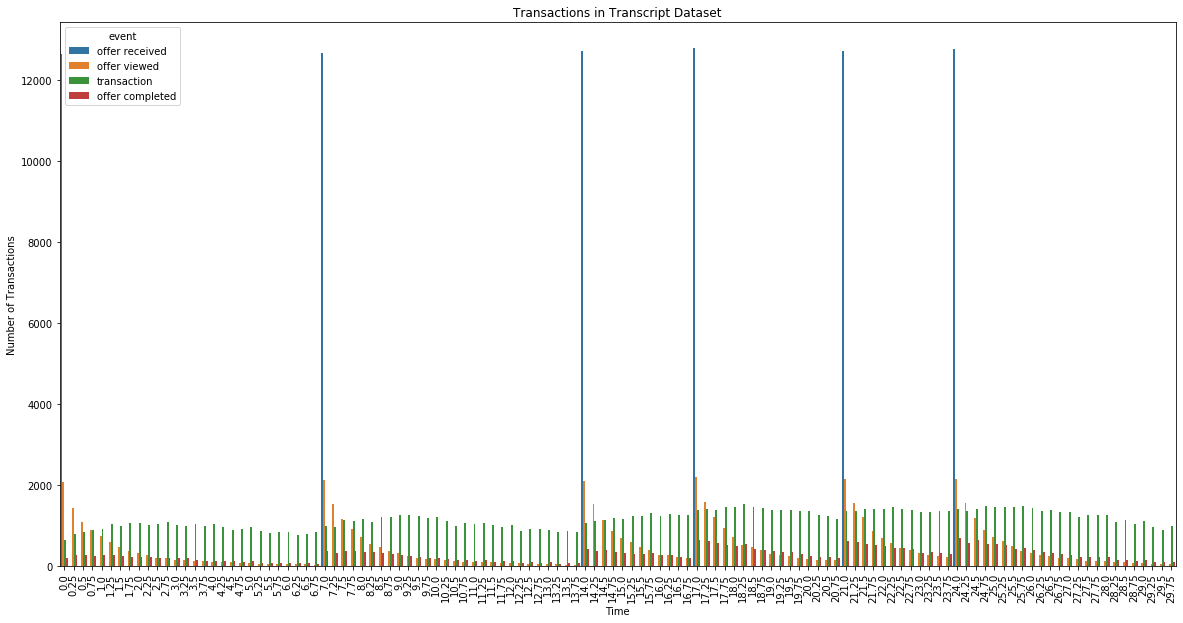

In [67]:
#what's the distribution of the time value
plt.figure(figsize=(20,10))
sns.countplot(transcript.time, hue = transcript.event)
plt.xticks(rotation=90)
plt.title('Transactions in Transcript Dataset')
plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.show()

In [68]:
transcript[transcript.event == 'offer received'].time.value_counts()
##only 6 times that offers are received 

17.0    12778
24.0    12765
14.0    12711
21.0    12704
7.0     12669
0.0     12650
Name: time, dtype: int64

In [69]:
# are offers sent only at the same time? --NO
transcript[(transcript.event == 'offer received') & (transcript.value == '9b98b8c7a33c4b65b9aebfe6a799e6d9')].time.value_counts()

24.0    1326
7.0     1296
14.0    1275
17.0    1274
21.0    1261
0.0     1245
Name: time, dtype: int64

In [146]:
# separate transactions out from offers table. Then establish of transactions were 'influenced' or not
transactions = transcript[transcript.event == 'transaction'][['person','value','time']]
offers = transcript[transcript.event != 'transaction']

transactions.head()

,person,value,time
12654,02c083884c7d45b39cc68e1314fec56c,0.83,0.0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56,0.0
12659,54890f68699049c2a04d415abc25e717,13.23,0.0
12670,b2f1cd155b864803ad8334cdf13c4bd2,19.51,0.0
12671,fe97aa22dd3e48c8b143116a8403dd52,18.97,0.0


In [147]:
#pivot for each person and subsequent offer
offers = offers.pivot_table(values = 'time',index = ['person','value'], columns = 'event').reset_index()
offers.columns = ['person','offer','time_completed', 'time_received','time_viewed']
offers.head()

,person,offer,time_completed,time_received,time_viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.00,24.0,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,14.0,15.5
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,7.0,8.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.25,17.0,19.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,22.00,21.0,22.5


In [148]:
#what is the completeness of the data? 
offers[offers.offer == '3f207df678b143eea3cee63160fa8bed']

,person,offer,time_completed,time_received,time_viewed
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,14.0,15.50
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,NaN,0.0,0.25
20,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,NaN,14.0,15.50
27,004b041fbfe44859945daa2c7f79ee64,3f207df678b143eea3cee63160fa8bed,NaN,7.0,NaN
38,0056df74b63b4298809f0b375a304cf4,3f207df678b143eea3cee63160fa8bed,NaN,21.0,22.00
...,...,...,...,...,...
63224,ffc77312ccda49fca19506f1cdf44923,3f207df678b143eea3cee63160fa8bed,NaN,21.0,NaN
63228,ffc8a38e0972421785b00f80c92c8085,3f207df678b143eea3cee63160fa8bed,NaN,0.0,NaN
63235,ffd810f301ad42d6bfe98c4ba6ee4125,3f207df678b143eea3cee63160fa8bed,NaN,14.0,14.25
63264,fff0f0aac6c547b9b263080f09a5586a,3f207df678b143eea3cee63160fa8bed,NaN,15.5,19.25


In [149]:
#merge offers dataframe with portfolio to establish timelines of influence
offers = offers.merge(portfolio, how = 'left',left_on='offer', right_on= 'id').drop(columns='id')

offers['end_of_influence'] = offers.apply(lambda x: min([x.time_received+x.duration, x.time_completed]),axis = 1)
offers.head()

,person,offer,time_completed,time_received,time_viewed,reward,difficulty,duration,web,social,email,mobile,bogo,discount,informational,end_of_influence
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.00,24.0,NaN,2,10,7,1,0,1,1,0,1,0,24.00
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,14.0,15.5,0,0,4,1,0,1,1,0,0,1,18.00
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,7.0,8.0,0,0,3,0,1,1,1,0,0,1,10.00
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.25,17.0,19.0,5,5,5,1,1,1,1,1,0,0,17.25
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,22.00,21.0,22.5,2,10,10,1,1,1,1,0,1,0,22.00


In [150]:
# establish if transactions were 'influenced' or not, and by which offer
def influenced_check (trns_row, offers=offers):
    '''
    Checks if each transaction is influenced by an offer or not
    '''
    # trns_row: person, value, time
    
    # filter offers table for person
    person_offers = offers[offers.person == trns_row.person]

    #cycle through offers
    for _, offer_row in person_offers.iterrows():
        
        #if transaction was within span of influence
        #time viewed is not nan, transaction time is > time viewed, and trs time is < end of influence
        if (offer_row.time_viewed != np.nan) & (trns_row.time >=offer_row.time_viewed) & (trns_row.time <=offer_row.end_of_influence):
            return [True, offer_row.offer ]

    #if transaction was outside of any influence span
    return [False, np.nan]


In [145]:
#loop through all transactions to test if it was influenced. TAKES LONG TIME
tmp = transactions.apply(lambda x: influenced_check(x,offers), axis=1).apply(pd.Series)
tmp.columns = ['influenced','offer']
transactions = pd.concat([transactions,tmp],axis=1)

transactions.head(20)



,person,value,time,test1,test2,0,1
12654,02c083884c7d45b39cc68e1314fec56c,0.83,0.0,0,1,True,ae264e3637204a6fb9bb56bc8210ddfd
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56,0.0,0,1,True,2906b810c7d4411798c6938adc9daaa5
12659,54890f68699049c2a04d415abc25e717,13.23,0.0,0,1,False,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,19.51,0.0,0,1,False,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,18.97,0.0,0,1,False,NaN
12678,629fc02d56414d91bca360decdfa9288,33.9,0.0,0,1,True,9b98b8c7a33c4b65b9aebfe6a799e6d9
12686,bbeb54e861614fc7b22a8844f72dca6c,0.22,0.0,0,1,False,NaN
12687,a97e6f33219c432db82acfa0d19c602d,18.59,0.0,0,1,False,NaN
12691,676506bad68e4161b9bbaffeb039626b,18.01,0.0,0,1,True,ae264e3637204a6fb9bb56bc8210ddfd
12696,8f7dd3b2afe14c078eb4f6e6fe4ba97d,19.11,0.0,0,1,True,4d5c57ea9a6940dd891ad53e9dbe8da0


In [103]:
offers[offers.person == '02c083884c7d45b39cc68e1314fec56c']

,person,offer,time_completed,time_received,time_viewed,reward,difficulty,duration,web,social,email,mobile,bogo,discount,informational,end_of_influence
647,02c083884c7d45b39cc68e1314fec56c,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,17.0,NaN,5,20,10,1,0,1,0,0,1,0,27.0
648,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,NaN,0.0,0.0,10,10,7,0,1,1,1,1,0,0,7.0


In [30]:
profile.head(20)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [31]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [32]:
transcript.time.value_counts()

17.00    17030
24.00    17015
21.00    16822
14.00    16302
7.00     16150
         ...  
13.25      940
13.75      938
6.50       914
6.75       910
6.25       894
Name: time, Length: 120, dtype: int64